In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!git clone https://github.com/Florisbruinsma/GoGame

Cloning into 'GoGame'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 231 (delta 126), reused 113 (delta 13), pack-reused 0
Receiving objects: 100% (231/231), 4.04 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

from GoGame.GoGame import GoGame
from GoGame.Model import Model
from GoGame.Agent import A2CAgent

# import gym
%load_ext tensorboard
from tensorflow.keras import backend
from tensorflow.keras import callbacks
import os
import time
import numpy as np
# %tensorboard — logdir logs

from tensorflow.python.client import device_lib

TensorFlow 2.x selected.
2.0.0
True


In [0]:
BOARDSIZE = 9
MAXTURNS = (BOARDSIZE*BOARDSIZE)-BOARDSIZE

model_name = 'goGameV4Size'+str(BOARDSIZE)
path = "/content/drive/My Drive/colab/saved_model_data/"
save_path = path + "{}.h5".format(model_name)
log_dir = path + "/logs"
log_file = log_dir + '/{}_log.txt'.format(model_name)
callbacks = None

In [0]:
# tensorboard_callback = callbacks.TensorBoard(log_dir, histogram_freq=1,write_images=True,write_grads=True,write_graph=True,update_freq='batch')
# callbacks = [tensorboard_callback]

In [0]:
# %tensorboard --logdir "/content/drive/My Drive/colab/saved_model_data/logs/train"

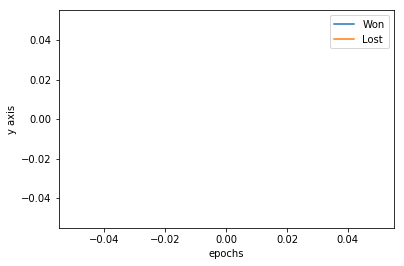

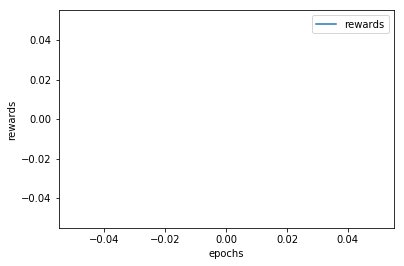

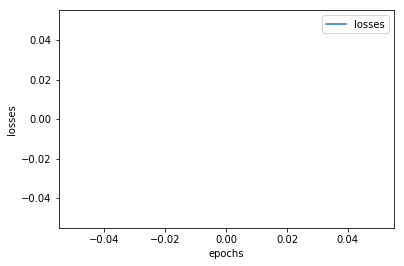

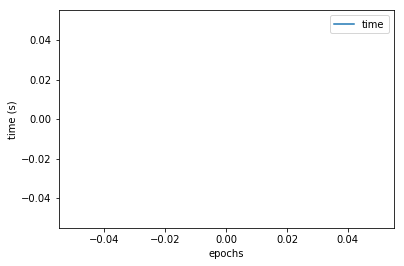

ValueError: ignored

In [8]:
if(os.path.isfile(log_file)):
    import matplotlib.pyplot as plt
    import csv

    epochs = []
    won = []
    lost = []
    rewards = []
    losses = []
    time_val = []
    larning_rate = []
    with open(log_file, 'r') as csvFile:
        reader = csv.reader(csvFile)
        first_row = True
        for row in reader:
            if(not first_row):
                epochs.append(      int(row[0]))
                larning_rate.append(float(row[1]))
                won.append(         int(row[2]))
                lost.append(        int(row[3])-int(row[2]))
                rewards.append(     float(row[4]))
                losses.append(      float(row[5]))
                time_val.append(    float(row[6]))
            else:
                first_row = False


    plt.plot(epochs, won, label="Won")
    plt.plot(epochs, lost, label="Lost")
    plt.plot()

    plt.xlabel("epochs")
    plt.ylabel("y axis")
    plt.legend()
    plt.show()
    #--------------------------------------------
    plt.plot(epochs, rewards, label="rewards")

    plt.xlabel("epochs")
    plt.ylabel("rewards")
    plt.legend()
    plt.show()
    #--------------------------------------------
    plt.plot(epochs, losses, label="losses")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.legend()
    plt.show()
    #--------------------------------------------
    plt.plot(epochs, time_val, label="time")

    plt.xlabel("epochs")
    plt.ylabel("time (s)")
    plt.legend()
    plt.show()
    #--------------------------------------------
    import seaborn as sns
    sns.regplot(epochs, won, label="won")
    sns.regplot(epochs, lost, label="lost")
    plt.legend()
    plt.show()

In [0]:
try:
    START_EPOCH = epochs[-1] +1
except:
    START_EPOCH = 0
EPOCHS = 500
EPISODES = 200
LEARNINGRATE = 0.0005
WINNING_FACTOR = 1
LOSING_FACTOR = 1

In [0]:
env = GoGame(BOARDSIZE, maxTurns=MAXTURNS)

model = Model(num_actions=env.action_space.n, callbacks=callbacks)
agent = A2CAgent(model,lr=LEARNINGRATE)
agent.test(env,render=False)

if(os.path.isfile(save_path)):
    model.load_weights(save_path)
    print("model loaded")
else:
    print("new model")

if(not os.path.isfile(log_file)):
    print("making new log file")
    with open(log_file, "w") as f:
        f.write("Epochs,LearningRate,Won,Lost,Rewards,Losses,Time\n")
# model.action_value(env.reset()[None, :])#build the model
model.summary()

for epoch in range(START_EPOCH,START_EPOCH + EPOCHS):
    time_start = time.time()
    backend.clear_session()
    rewards_history, episode_wins, losses = agent.train(
        env,
        max_steps=MAXTURNS,
        episodes=EPISODES, 
        info=False, 
        winning_factor = WINNING_FACTOR, 
        losing_factor = LOSING_FACTOR)
    print("epoch = {:2} | lr = {:8.6f} | won {:3}/{:3} matches | mean rewards = {:7.2f} | mean losses = {:7.2f} | epoch time = {:6.2f} sec".format(epoch, LEARNINGRATE, episode_wins.count(1), len(episode_wins), np.mean(rewards_history), np.mean(losses), (time.time()-time_start)))
    model.save_weights(save_path)
    print("model saved")
    with open(log_file, "a") as f:
        f.write("{:2},{:8.6f},{:3},{:3},{:7.2f},{:7.2f},{:6.2f}\n".format(epoch, LEARNINGRATE, episode_wins.count(1), len(episode_wins), np.mean(rewards_history), np.mean(losses), (time.time()-time_start)))

# print("Finished training, testing...")
# for _ in range(1):
#     print("total score = %d " % agent.test(env,render=True))

new model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  83968     
_________________________________________________________________
dense_1 (Dense)              multiple                  41984     
_________________________________________________________________
value (Dense)                multiple                  513       
_________________________________________________________________
policy_logits (Dense)        multiple                  83025     
_________________________________________________________________
probability_distribution (Pr multiple                  0         
Total params: 209,490
Trainable params: 209,490
Non-trainable params: 0
_________________________________________________________________
epoch =  0 | lr = 0.000500 | won   1/200 matches | mean rewards = -2962.75 | mean losses = 993437.44 | epoch ti